In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# Author: Selvaria
# IEEE-CIS的EDA（Exploratory Data Analysis探索性数据分析）
# https://www.kaggle.com/xhlulu/ieee-fraud-xgboost-with-gpu-fit-in-40s

import os

import numpy as np
import pandas as pd

#这里将TransactionID设为index是为了合并时能够将二者的数据全部保存到一个表里，不会错漏
train_transaction = pd.read_csv('d:/data/Kaggle/IEEE-CIS/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('d:/data/Kaggle/IEEE-CIS/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('d:/data/Kaggle/IEEE-CIS/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('d:/data/Kaggle/IEEE-CIS/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('d:/data/Kaggle/IEEE-CIS/sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

(590540, 433)
(506691, 432)


In [9]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [2]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1] #nunique()用于获取列唯一值的统计数量，注意默认去掉了null值
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

one_value_cols

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


[]

In [4]:
del train_identity, train_transaction, test_identity, test_transaction

Text(0.5,1,'Distribution of id_01 variable')

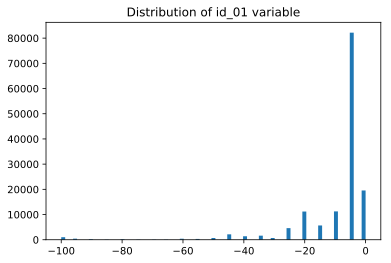

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.hist(train['id_01'].dropna(), bins=77) #必须加dropna()或fillna()，否则画不出图
plt.title('Distribution of id_01 variable')

(array([  1.20000000e+01,   2.30000000e+01,   3.50000000e+01,
          8.50000000e+01,   2.00000000e+01,   6.39150000e+04,
          1.95200000e+03,   2.09000000e+02,   6.80000000e+01,
          5.00000000e+00]),
 array([-13. , -10.7,  -8.4,  -6.1,  -3.8,  -1.5,   0.8,   3.1,   5.4,
          7.7,  10. ]),
 <a list of 10 Patch objects>)

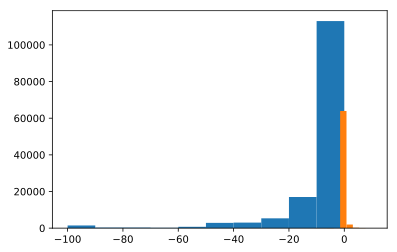

In [21]:
plt.hist(train['id_01'].dropna()) 
plt.hist(train['id_03'].dropna()) 

In [69]:
print(train['id_01'].shape)
train['TransactionDT'].value_counts(dropna=False, normalize=True) #normalize是返回比例

(590540,)


9474817     0.000014
11576951    0.000008
7236588     0.000008
4397066     0.000008
8468062     0.000007
8020359     0.000007
7337054     0.000007
5334992     0.000007
1971839     0.000007
1962054     0.000007
10342227    0.000007
2073296     0.000007
8218707     0.000007
1544629     0.000007
8218708     0.000007
2550725     0.000005
757391      0.000005
1037520     0.000005
1888439     0.000005
1982943     0.000005
8547204     0.000005
15386360    0.000005
1786311     0.000005
493263      0.000005
10889000    0.000005
3033280     0.000005
15209310    0.000005
1623192     0.000005
12868941    0.000005
496100      0.000005
              ...   
5414145     0.000002
1213698     0.000002
15032692    0.000002
7517444     0.000002
6470917     0.000002
12758279    0.000002
4379912     0.000002
5515188     0.000002
13471361    0.000002
5432590     0.000002
12078081    0.000002
144660      0.000002
8535317     0.000002
4336919     0.000002
15777988    0.000002
1201432     0.000002
4365811     0

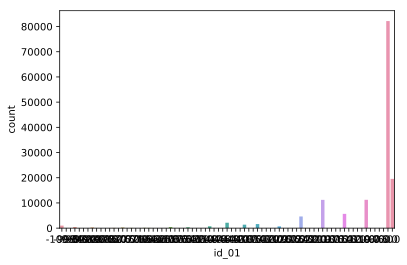

In [11]:
import seaborn as sns

sns.countplot('id_01', data=train)

In [13]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

NaN            0.761273
 100.000000    0.225492
 95.080002     0.002085
 95.160004     0.001277
 97.120003     0.000745
Name: id_11, dtype: float64

Text(0.5,1,'Distribution of transactiond dates')

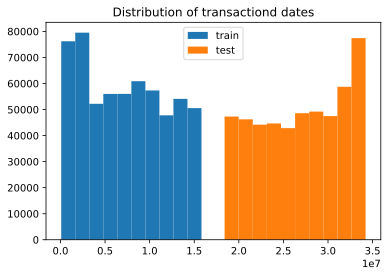

In [18]:
plt.hist(train['TransactionDT'], label='train')
plt.hist(test['TransactionDT'], label='test')
plt.legend()# 显示图例
plt.title('Distribution of transactiond dates')

In [23]:
#空值过多的列

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.95]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.95]

print(many_null_cols)
print(many_null_cols_test)

['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [48]:
#单一值过多的列

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.95]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.95]
print(big_top_value_cols)
print(len(big_top_value_cols))
print(big_top_value_cols_test)
print(len(big_top_value_cols_test))

#下面是去重，可以不用，最后一起整
cols_top_too_much = [x for x in big_top_value_cols if x in big_top_value_cols_test]
print(cols_top_too_much)
print(len(cols_top_too_much))

['isFraud', 'C3', 'V104', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V125', 'V135', 'V281', 'V286', 'V297', 'V300', 'V301', 'V305', 'V311', 'V319', 'id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
39
['C3', 'V14', 'V25', 'V26', 'V27', 'V28', 'V65', 'V66', 'V68', 'V88', 'V89', 'V98', 'V101', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V125', 'V129', 'V132', 'V286', 'V305', 'V311', 'id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
45
['C3', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V125', 'V286', 'V305', 'V311', 'id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
31


In [50]:
cols_to_drop = list(set(many_null_cols + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

52

In [66]:
%%time

df_where = train['id_01'].copy()
df_con = df_where.value_counts(dropna=False, normalize=True)
#print(df_con)
test_v = df_con.values
print(test_v)
print(df_con[df_con==test_v[1]].index.tolist()[0])
#df_where.head()
print(type(df_con))
#df_h = df_where.where(df_where.value_counts(dropna=False, normalize=True)>0.03, other=-9999) #如果cond为真，保持原来的值，否则替换为other
#df_h.value_counts(dropna=False, normalize=True)
for index in df_where.index:
    col_val = df_where.loc[index]
    if df_con.loc[col_val]<0.02:
        df_where.loc[index] = -9999
    else:
        continue
        
df_where.value_counts(dropna=False, normalize=True)

[  7.55760829e-01   1.39143834e-01   3.31137603e-02   1.90622142e-02
   1.89843194e-02   9.60815525e-03   7.82842822e-03   3.62888204e-03
   2.74663867e-03   2.34531107e-03   1.71368578e-03   1.20059606e-03
   1.15487520e-03   7.24760389e-04   6.94279812e-04   5.41876926e-04
   3.72540387e-04   3.62380194e-04   1.64256443e-04   1.57482982e-04
   1.47322789e-04   1.40549328e-04   3.89474041e-05   2.54004809e-05
   2.54004809e-05   2.54004809e-05   2.20137501e-05   2.03203847e-05
   1.69336539e-05   1.69336539e-05   1.52402885e-05   1.52402885e-05
   1.52402885e-05   1.35469232e-05   1.01601924e-05   8.46682697e-06
   8.46682697e-06   8.46682697e-06   8.46682697e-06   6.77346158e-06
   6.77346158e-06   6.77346158e-06   5.08009618e-06   5.08009618e-06
   5.08009618e-06   3.38673079e-06   3.38673079e-06   3.38673079e-06
   3.38673079e-06   3.38673079e-06   3.38673079e-06   3.38673079e-06
   3.38673079e-06   3.38673079e-06   3.38673079e-06   1.69336539e-06
   1.69336539e-06   1.69336539e-06

In [99]:
def GET_CR(X, p = 0.02):
    OVER_CR = X.value_counts().index[X.value_counts() > p * len(X)]
    OVER_CR = list(OVER_CR)
    ISIN = list(map(lambda x:x in OVER_CR, X))
    y = np.where(ISIN, X, -9999)
    return y

df_where = train[['id_01']]
print(type(df_where))
#print(df_where.value_counts())
#GET_CR(df_where)
data = df_where.apply(GET_CR)
data.head()
data['id_01'].value_counts(dropna=False, normalize=True)

<class 'pandas.core.frame.DataFrame'>


-9999.0    0.827742
-5.0       0.139144
 0.0       0.033114
Name: id_01, dtype: float64

In [91]:
from pandas import DataFrame

a=[1,1,2,2,4]#列表a
b=[5,5,7,6,7]#列表b
c={"a" : a,
   "b" : b}#将列表a，b转换成字典
data=DataFrame(c)#将字典转换成为数据框
print(data)
print(type(data))

   a  b
0  1  5
1  1  5
2  2  7
3  2  6
4  4  7
<class 'pandas.core.frame.DataFrame'>


In [98]:
train['id_01'].value_counts(dropna=False, normalize=True)

NaN       0.755761
-5.0      0.139144
 0.0      0.033114
-10.0     0.019062
-20.0     0.018984
-15.0     0.009608
-25.0     0.007828
-45.0     0.003629
-35.0     0.002747
-40.0     0.002345
-100.0    0.001714
-50.0     0.001201
-30.0     0.001155
-95.0     0.000725
-60.0     0.000694
-55.0     0.000542
-80.0     0.000373
-90.0     0.000362
-70.0     0.000164
-65.0     0.000157
-85.0     0.000147
-75.0     0.000141
-18.0     0.000039
-6.0      0.000025
-12.0     0.000025
-11.0     0.000025
-16.0     0.000022
-21.0     0.000020
-7.0      0.000017
-14.0     0.000017
            ...   
-29.0     0.000003
-71.0     0.000003
-99.0     0.000003
-61.0     0.000003
-46.0     0.000003
-88.0     0.000003
-64.0     0.000003
-34.0     0.000002
-28.0     0.000002
-42.0     0.000002
-43.0     0.000002
-52.0     0.000002
-33.0     0.000002
-89.0     0.000002
-47.0     0.000002
-32.0     0.000002
-51.0     0.000002
-92.0     0.000002
-54.0     0.000002
-57.0     0.000002
-58.0     0.000002
-94.0     0.

In [56]:
df_where.value_counts(dropna=False, normalize=True)

NaN        0.761273
 100.0     0.225492
-9999.0    0.013235
Name: id_11, dtype: float64

In [68]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT'], axis=1)
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [70]:
X.reset_index(drop=True, inplace=True)
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
